# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [84]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.43KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

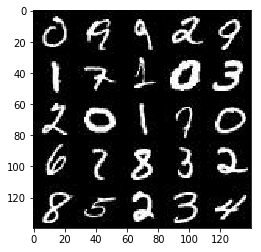

In [85]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

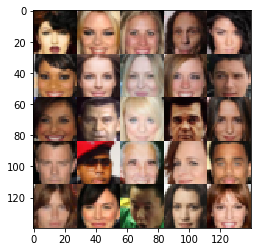

In [86]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [87]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [88]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputImages = tf.placeholder(tf.float32, shape = [None, image_width, image_height, image_channels], name = "input_images")
    zInput = tf.placeholder(tf.float32, shape = [None, z_dim], name = "z_input")
    learningRate = tf.placeholder(tf.float32, shape = None, name = "learning_rate")
    
    return inputImages, zInput, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [89]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    #Input 28x28x3
    
    with tf.variable_scope("discriminator", reuse = reuse) as disc_scope:
        x1 = tf.layers.conv2d(images, 48, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x48
        
        x2 = tf.layers.conv2d(relu1, 96, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x96
        
        x3 = tf.layers.conv2d(relu2, 192, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x192
        
        flat = tf.reshape(relu3, (-1, 4*4*192))
        # 3072
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [98]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse = (not is_train)):
    
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        # 4x4#384

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        # 8x8#192

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        #16x16x128

        logits32 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32 x 32 x out_channel_dim
        
        logits28 = tf.slice(logits32, [0,2,2,0], [-1,28,28,-1])
        #print(logits28.shape)
        # 28 x 28 x out_channel_dim

        out = tf.tanh(logits28)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [99]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    labels = tf.ones_like(d_model_real) * 0.95

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=labels)
        )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [100]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [101]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [102]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    real_size = (28, 28, 3)
    print(data_shape)
    
    tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2.0
                
                # Sample random noize
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z })
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z })
                
                if steps % 10 == 0:
                    # Show loss
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z,  data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.5065... Generator Loss: 1.6861
Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 1.4467
Epoch 1/2... Discriminator Loss: 0.7527... Generator Loss: 2.6242
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 1.0072
Epoch 1/2... Discriminator Loss: 0.6901... Generator Loss: 3.8589
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 0.5803... Generator Loss: 1.7394
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.2272
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 1.8115


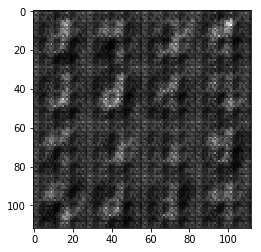

Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 2.3163
Epoch 1/2... Discriminator Loss: 0.5878... Generator Loss: 1.8084
Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 1.4799
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 1.5998
Epoch 1/2... Discriminator Loss: 0.8742... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 0.9739
Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 1.2109
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 1.0606
Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 1.0001
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.4825


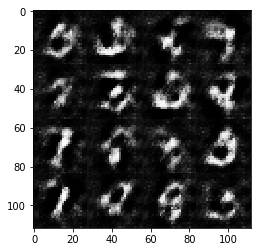

Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 2.1471
Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.0529... Generator Loss: 1.1543
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 1.6872
Epoch 1/2... Discriminator Loss: 0.9396... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 0.9063
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 1.2551
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.1923
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.2765
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 1.3937


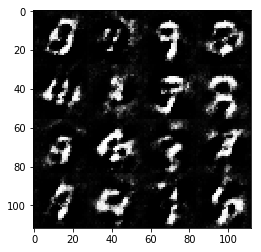

Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.2043
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.1000
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 2.1162
Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 1.4703
Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.0743
Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 1.1219... Generator Loss: 1.7590
Epoch 1/2... Discriminator Loss: 1.0072... Generator Loss: 1.9856
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 0.7973
Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 0.9433


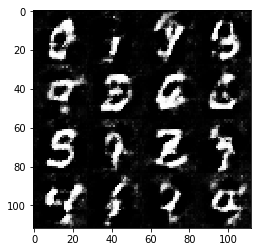

Epoch 1/2... Discriminator Loss: 0.8322... Generator Loss: 1.3225
Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 1.2455
Epoch 1/2... Discriminator Loss: 0.9182... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 1.5527
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 2.3794
Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 1.9749
Epoch 1/2... Discriminator Loss: 0.8744... Generator Loss: 1.2862
Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 0.6444
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.5944


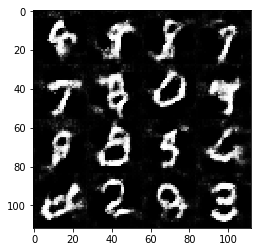

Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 1.4026
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 1.9027
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 0.5819
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 1.5832
Epoch 1/2... Discriminator Loss: 1.0845... Generator Loss: 1.8099
Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 1.4110
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 0.6932


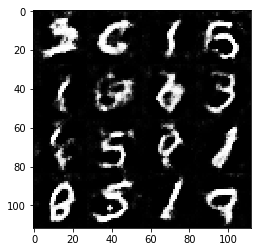

Epoch 1/2... Discriminator Loss: 0.9905... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.1752
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 1.6451
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 1.7127
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.5982
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 1.1433


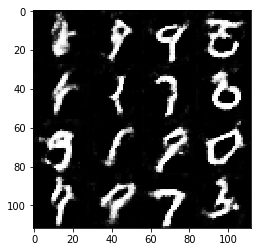

Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.4482
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 1.0911
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 0.8941
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.3898
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 0.8742
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 1.1564
Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 1.4367
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.4107


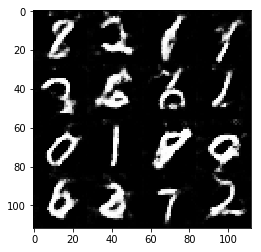

Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 1.0202
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 0.9635
Epoch 1/2... Discriminator Loss: 1.1393... Generator Loss: 0.6241
Epoch 1/2... Discriminator Loss: 1.0442... Generator Loss: 1.2333
Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 0.6348
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 1.4879
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 0.8385
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 0.8956


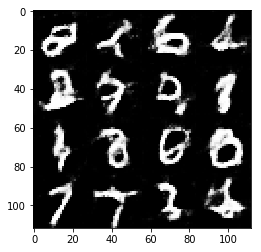

Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 1.0126
Epoch 1/2... Discriminator Loss: 1.0276... Generator Loss: 0.9026
Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 1.0953
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 1.4469
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.2391
Epoch 2/2... Discriminator Loss: 0.9264... Generator Loss: 0.9909
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.1433
Epoch 2/2... Discriminator Loss: 1.2303... Generator Loss: 0.5338


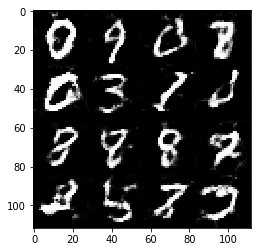

Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 1.5915
Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 0.9503
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 0.9101
Epoch 2/2... Discriminator Loss: 2.5853... Generator Loss: 0.1369
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.1922
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.7610


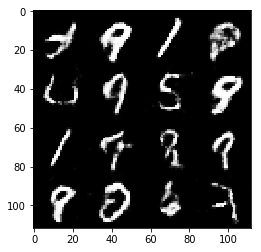

Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.2296
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 1.8337
Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 0.9249
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 1.4241
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.5467
Epoch 2/2... Discriminator Loss: 0.9067... Generator Loss: 1.3536


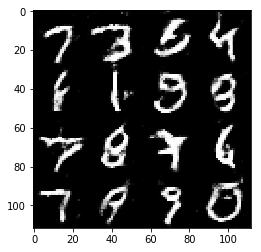

Epoch 2/2... Discriminator Loss: 1.0262... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.3378
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 1.3220
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.1785
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 0.9981
Epoch 2/2... Discriminator Loss: 0.9399... Generator Loss: 1.4221
Epoch 2/2... Discriminator Loss: 2.3176... Generator Loss: 0.1625
Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.1856
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 0.9711


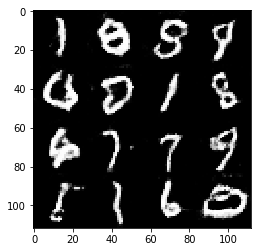

Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.1383
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.5250
Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.2165... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 0.8476
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.1793... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.6287
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 1.1151
Epoch 2/2... Discriminator Loss: 2.1109... Generator Loss: 3.4247


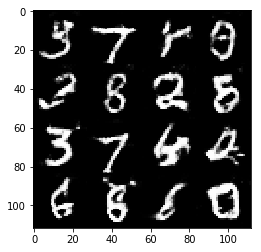

Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 1.0831
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 1.0012... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.1345... Generator Loss: 0.6057
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 0.8813
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.1251
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 1.0803
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.3800
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.3687
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.6375


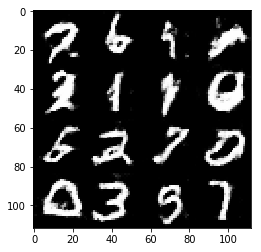

Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.6344
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 1.1120
Epoch 2/2... Discriminator Loss: 0.9218... Generator Loss: 0.9195
Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 1.4329
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 0.8536
Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 1.1659
Epoch 2/2... Discriminator Loss: 1.0398... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 0.9228... Generator Loss: 1.1524
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 0.7563


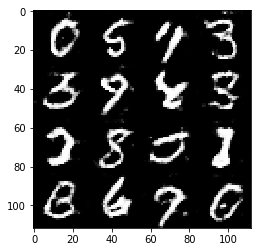

Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 0.8984
Epoch 2/2... Discriminator Loss: 1.0643... Generator Loss: 2.0248
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 1.5662
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 1.5929
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 1.1607
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 2.1976


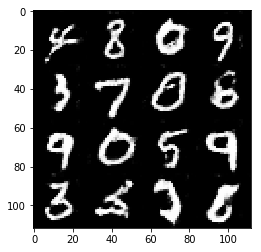

Epoch 2/2... Discriminator Loss: 0.7500... Generator Loss: 1.2427
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.4768
Epoch 2/2... Discriminator Loss: 1.7006... Generator Loss: 0.3317
Epoch 2/2... Discriminator Loss: 0.8269... Generator Loss: 1.2033
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.0349
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 0.7886... Generator Loss: 1.7935
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 1.8791
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 0.8084
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 0.5791


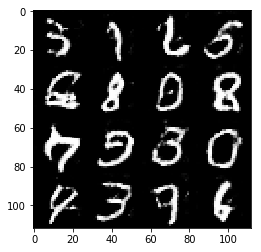

Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 1.3257
Epoch 2/2... Discriminator Loss: 0.8021... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 0.8959
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 2.0266... Generator Loss: 2.5894
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.8688


IndexError: list index out of range

In [103]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [96]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

(202599, 28, 28, 3)


IndexError: list index out of range

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.